Group 19 Final

### Introduction:

### tweet_df Acquisition:

In [1]:
import pandas as pd
import nltk
import requests
import twint
import nest_asyncio
import json
import re
from textblob import TextBlob
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nest_asyncio.apply()

[nltk_data] Downloading package stopwords to C:\Users\L
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\L
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\L S\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to C:\Users\L
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# c = twint.Config()
# c.Search = 'Nuclear Energy'
# c.Limit = 5000
# c.Store_json = True
# c.Output = 'twit_data.json'
# twint.run.Search(c)

In [ ]:
# c = twint.Config()
# c.Search = 'Nuclear Power'
# c.Limit = 5000
# c.Store_json = True
# c.Output = 'twit_data.json'
# twint.run.Search(c)

### dataremoved Cleaning:

In [4]:
f = open(r'twit_data.json', 'rb')
data = [json.loads(line) for line in f]
tweet_df = pd.DataFrame(data)
tweet_df = tweet_df[['tweet','link']]
tweet_df = tweet_df.drop_duplicates()
dataremoved = tweet_df[~tweet_df.iloc[:,0].str.contains('Ukraine')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('ukraine')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Ukrainian')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('ukrainian')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Ukrainians')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('ukrainians')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Zaporizhzhia')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('war')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('russia')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Russia')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('russian')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Russian')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('russians')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Russians')]

In [ ]:
cleaned_tweets = []
words = []
for tweet in dataremoved['tweet']:
    clean = re.sub(r"(http[s]?\://\S+)|([\[\(].*[\)\]])|([#@]\S+)|\n", "", tweet)
    clean = re.sub(r"\d", '', clean)
    clean = re.sub(r"'\S+", '', clean)
    clean = clean.replace('.', '').replace(';', '').lower()
    words += re.findall(r"(?:\w+|'|’)+", clean)
    cleaned_tweets.append(clean)

stopwords = nltk.corpus.stopwords.words("english")
standardized = [w for w in words if w not in stopwords]

# removing other symbols
corpus = [[re.sub('[^a-zA-Z ]', ' ', document)] for document in cleaned_tweets]
#tokenizing
corpus_tokenized = [nltk.word_tokenize(document[0]) for document in corpus]
# stop words
stopwords = nltk.corpus.stopwords.words("english")
corpus_tokenized = [[word for word in document if word not in stopwords] for document in corpus_tokenized]
#lemmatizing
nltk.download('wordnet')
corpus_lemmatized = [[nltk.WordNetLemmatizer().lemmatize(word) for word in document] for document in corpus_tokenized]
#stitching back together
corpus = [' '.join(document) for document in corpus_lemmatized]

(another cleaning method-- on a per tweet basis. we need to sort this out w/ the code above.)

In [2]:
#%%
#all.csv is in the github, it is all of the tweets including the training set tweets we worked on, with the ukraine/russian/war tweets filtered out
data = pd.read_csv('all.csv',header=None)
#%%
data = data.iloc[:,1]
data.columns = ['tweets']

In [3]:
cleaned_tweets = []
words = []
for tweet in data:
    clean = re.sub(r"(http[s]?\://\S+)|([\[\(].*[\)\]])|([#@]\S+)|\n", " ", tweet)
    clean = re.sub(r"\d", '', clean)
    clean = re.sub(r"'\S+", '', clean)
    clean = clean.replace('.', '').replace(';', '').lower()
    words += re.findall(r"(?:\w+|'|’)+", clean)
    cleaned_tweets.append(clean)
    
    
# removing other symbols
corpus = [[re.sub('[^a-zA-Z ]', ' ', document)] for document in cleaned_tweets]
#tokenizing
corpus_tokenized = [nltk.word_tokenize(document[0]) for document in corpus]
# stop words
stopwords = nltk.corpus.stopwords.words("english")
corpus_tokenized = [[word for word in document if word not in stopwords] for document in corpus_tokenized]
#lemmatizing
corpus_lemmatized = [[nltk.WordNetLemmatizer().lemmatize(word) for word in document] for document in corpus_tokenized]
#stitching back together
corpus_string = [' '.join(document) for document in corpus_lemmatized]

### First Model: Preliminary LDA

We will be using the gensim package's LDA model because it seems to have more LDA-specific features such as coherence score calculation.

In [4]:
import numpy as np
import re
import string
#import spacy
import gensim
from gensim import corpora
#import pyLDAvis
#import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
dictionary = corpora.Dictionary(corpus_lemmatized)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in corpus_lemmatized]

In [6]:
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=2, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [8]:
# topic display
posterior = lda_model.print_topics()
two_topic_LDA = pd.DataFrame(posterior)[1]
two_topic_LDA = two_topic_LDA.transpose()
two_topic_LDA.index = ['topic ' + str(i) for i in range(0,2)]
two_topic_LDA.name = 'words'

two_topic_LDA

topic 0    0.062*"nuclear" + 0.056*"power" + 0.023*"plant...
topic 1    0.057*"nuclear" + 0.048*"energy" + 0.018*"powe...
Name: words, dtype: object

In [9]:
# perplexity and coherence scores

print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus_lemmatized, dictionary=dictionary , coherence='u_mass')
if __name__ == "__main__":
    #freeze_support()
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.517665835863843

Coherence Score:  -4.271198409594465


We need to identify what number of LDA topics would work best as an input to k-NN.

In [10]:
#%% GRAPH FUNCTION

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [11]:
# build list of scores across different topic numbers

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=corpus_lemmatized, start=2, limit=50, step=1)


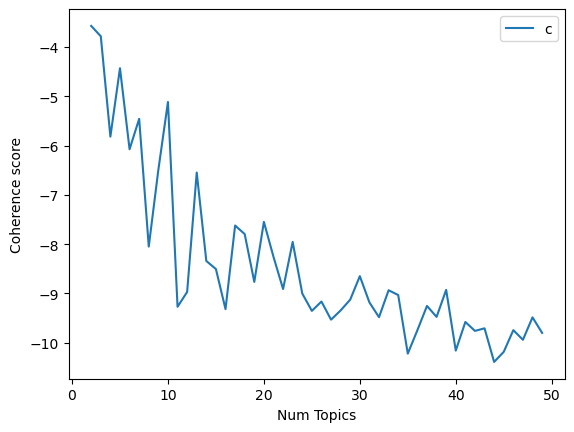

In [12]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [13]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of -3.5702
Num Topics = 3  has Coherence Value of -3.7804
Num Topics = 4  has Coherence Value of -5.8171
Num Topics = 5  has Coherence Value of -4.4289
Num Topics = 6  has Coherence Value of -6.0737
Num Topics = 7  has Coherence Value of -5.456
Num Topics = 8  has Coherence Value of -8.0493
Num Topics = 9  has Coherence Value of -6.4918
Num Topics = 10  has Coherence Value of -5.1139
Num Topics = 11  has Coherence Value of -9.272
Num Topics = 12  has Coherence Value of -8.9709
Num Topics = 13  has Coherence Value of -6.5466
Num Topics = 14  has Coherence Value of -8.3422
Num Topics = 15  has Coherence Value of -8.506
Num Topics = 16  has Coherence Value of -9.3199
Num Topics = 17  has Coherence Value of -7.6228
Num Topics = 18  has Coherence Value of -7.796
Num Topics = 19  has Coherence Value of -8.7672
Num Topics = 20  has Coherence Value of -7.5484
Num Topics = 21  has Coherence Value of -8.257
Num Topics = 22  has Coherence Value of -8.9112
Num T

Optimal number = 2??? hahahaha

INTERACTIVE ELEMENT CAN GO HERE

In [16]:
import pyLDAvis
import pyLDAvis.gensim_models
vis_data = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.show(vis_data, open_browser=False, local=False)

c:\Anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
c:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [07/Dec/2022 14:27:43] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2022 14:27:44] code 404, message Not Found
127.0.0.1 - - [07/Dec/2022 14:27:44] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


Vectorization

In [ ]:
#%% MATRIX TIME, THIS OUTPUT WILL GO INTO K-NN

tweet_vectors = pd.Series(0)
for i in range(len(doc_term_matrix)):    
    tweet_vectors[i] = lda_model.get_document_topics(doc_term_matrix[i], minimum_probability=0, minimum_phi_value=None, per_word_topics=False)

tweet_vectors_entries = [[tweet_vectors[i][0][1],tweet_vectors[i][1][1]] for i in range(len(tweet_vectors))]

LDA_tweet_frame = pd.DataFrame(tweet_vectors_entries, columns = ['Topic 0','Topic 1'])

### Second Model: K-NN

In [14]:
import pandas as pd
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Binarizer
import nltk

In [15]:
colnames=['tweets', 'label']
data = pd.read_csv("final_141B/trainingset_1_lemmatized.csv", names=colnames, header=None)

FileNotFoundError: [Errno 2] No such file or directory: 'final_141B/trainingset_1_lemmatized.csv'

In [ ]:
def one_hot_encoding_tweets(data):
    # 1. create a CountVectorizer
    vec = CountVectorizer(tokenizer = nltk.word_tokenize)
    # convert the type of "tweets" to str
    data["tweets"] = data["tweets"].astype(str)
    tweet_list = list(data['tweets'])
    freq = vec.fit_transform(tweet_list)
    # create one-hot encoding
    ohot = Binarizer().fit_transform(freq)
    # one-hot encoding
    corpus_binary = ohot.todense()

    # convert matrix to dataframe
    encoder_df = pd.DataFrame(corpus_binary)

    # create x and y for knn
    x = encoder_df
    y = data['label']

    return x,y


# create x, y for knn
x = one_hot_encoding_tweets(data)[0]
y = one_hot_encoding_tweets(data)[1]

In [ ]:
# test the optimal k for the accuracy
k_range = range(1, 31)
k_error = []
k_acc = []
optimal_k = 0
min_error = 1
max_acc = 0

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # the value of cv decides the ratio of training and testing data
    scores = cross_val_score(knn, x, y, cv=4, scoring='accuracy')
    # error rate
    error_rate = 1 - scores.mean()
    # record the best performance with value of k
    if error_rate < min_error:
        min_error = error_rate
        optimal_k = k
        max_acc = scores.mean()
    k_error.append(error_rate)
    # accuracy rate
    k_acc.append(scores.mean())

# plot: x is the k value, y is the error value
plt.plot(k_range, k_error)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Error')
plt.show()
print("the optimal k is: ", optimal_k)

In [ ]:
# check the effect of random_state for accuracy

# Import train_test_split function
from sklearn.model_selection import train_test_split
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Split dataset into training set and test set
# test which test_size produces the largest acc
test_size_range = range(0.1,0.4,0.1)
acc = 0
test_size_acc = []
test_size = []
for size in test_size_range:
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=size, random_state=0) # 80% training and 20% test
    # Create KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=25)

    # Train the model using the training sets
    knn.fit(X_train, y_train)

    # Predict the response for test dataset
    y_pred = knn.predict(X_test)
    # Model Accuracy, how often is the classifier correct?
    # calculate the accuracy
    acc_s = metrics.accuracy_score(y_test, y_pred)
    if acc <= acc_s:
        acc = acc_s
        print("test_size: ", size)
        print("Accuracy:", acc)
        test_size_acc.append(acc)
        test_size.append(size)

plt.plot(test_size, test_size_acc)
plt.xlabel('Test Size')
plt.ylabel('acc for KNN')
plt.show()

In [ ]:
# predict lables for test data using training data
def pred_label_for_test(train_data, data_test):
    merge_data = train_data.append(data_test, ignore_index=True)

    # %% for
    x = one_hot_encoding_tweets(merge_data)[0]
    y = one_hot_encoding_tweets(merge_data)[1]
    
    # convert 'negative', 'neutral', 'positive' into 3,2,1     
    enc = LabelEncoder()
    label_encoder = enc.fit(y)
    y = label_encoder.transform(y)

    # %% for labelled.csv and remainder.csv
    X_train = x.loc[:1174, :]
    y_train = y[:1175]

    X_test = x.loc[1175:, :]

    # Create KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=10)

    # Train the model using the training sets
    knn.fit(X_train, y_train)

    # Predict the response for test dataset
    y_pred = knn.predict(X_test)
    
    return y_pred, y_train


# drawing bar plots for data
def bar_plot_for_data(data_for_bar):
    req = np.array(np.unique(data_for_bar, return_counts=True)).T
    freq_data = sorted(
                        [(name, float(val)) for name, val in freq],
                         key=lambda x:x[1],
                         reverse=True
                        )

    colors_list = ['Red', 'Orange', 'Blue']
    p1 = plt.bar(*zip(*freq_data), color=colors_list)

    n = len(data_for_bar)
    for rect1 in p1:
        height = rect1.get_height()
        plt.annotate("{}%".format(round(height/n, 2)), (rect1.get_x() + rect1.get_width()/2,
                                            height+.05), ha="center", va="bottom", fontsize=15)

    plt.show()

In [ ]:
colnames = ['tweets', 'label']
data_labelled = pd.read_csv('labelled.csv', names=colnames, header=None)
data_labelled_cleaned = pd.read_csv('labelled_cleaned.csv', names=colnames, header=None)
colnames = ['tweets']
data_test = pd.read_csv("remainder.csv", names=colnames, header=None)
data_test['label'] = ""   # add one empty column "label"

# obtain the predication labels
y_pred_labelled = pred_label_for_test(data_labelled, data_test)[0]
y_pred_labelled_cleand = pred_label_for_test(data_labelled_cleaned, data_test)[0]

# draw barplots
bar_plot_for_data(y_pred_labelled)
bar_plot_for_data(y_pred_labelled_cleand)


In [ ]:
# bar plots with percentages
def pred_label_for_lda(train_lda, test_lda)
    # %% for labelled_LDA_vectors.csv and remainder_LDA_vectors.csv
    X_train = train_lda.loc[:1174, :1]
    y_train = train_lda.loc[:1174, 2]
    enc = LabelEncoder()
    label_encoder = enc.fit(y_train)
    y_train = label_encoder.transform(y_train)+1

    X_test = test_lda.loc[1175:, :]

    # Create KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=10)

    # Train the model using the training sets
    knn.fit(X_train, y_train)

    # Predict the response for test dataset
    y_pred = knn.predict(X_test)

In [ ]:
train_data_stopw = pd.read_csv("labelled_LDA_vectors_withStopwords.csv", header=None, skiprows=1)
test_data_stopw = pd.read_csv("remainder_LDA_vectors_withStopwords.csv", header=None, skiprows=1)

train_data = pd.read_csv("labelled_LDA_vectors.csv", header=None, skiprows=1)
test_data = pd.read_csv("remainder_LDA_vectors.csv", header=None, skiprows=1)

# obtain the predication labels
y_pred_lda = pred_label_for_lda(train_data_stopw, test_data_stopw)[0]
y_pred_lda_cleand = pred_label_for_lda(train_data, test_data)[0]

# draw barplots
bar_plot_for_data(y_pred_lda)
bar_plot_for_data(y_pred_lda_cleand)

### Third Model: VADER

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('vader_lexicon')

In [ ]:
tokenized_words = word_tokenize(corpus, "english")
score = SentimentIntensityAnalyzer().polarity_scores(corpus)
score

### Closing Statements: